### Crude Oil WTI

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt


# Đọc dữ liệu
df = pd.read_csv('../dataset/Crude Oil WTI.csv').dropna()

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]


In [50]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)


In [51]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,55.8
1,56.195
2,56.195
3,56.59
4,56.56
...,...
1914,78.775
1915,79.83
1916,79.23
1917,77.91


In [52]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [53]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

In [54]:
# Khởi tạo một mô hình DLM
myDLM = dlm(train_data.Price)

# Thêm trend
myDLM = myDLM + trend(degree=1, discount=0.9, name='linear_trend')

# Thêm seasonality
myDLM = myDLM + seasonality(period=7, discount=0.9, name='weekly_seasonality')

# Huấn luyện mô hình
myDLM.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = myDLM.predictN(N=len(y_test))

# Extract the last observation for initializing the forecast
last_observation = test_data.iloc[-1]['Price']

# Predict values for the test set based on actual data
predictions_test_actual = myDLM.predictN(N=len(test_data))

In [56]:
# Append test data to the DLM to incorporate its information
for i in range(len(test_data)):
    myDLM.append([test_data.iloc[i]['Price']])
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [57]:
# Dự đoán 30 ngày
future_predictions_30 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  
    future_predictions_30.append(future_prediction)
    myDLM.append([future_prediction])  
    myDLM.fit()  

# Dự đoán 60 ngày
future_predictions_60 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0] 
    future_predictions_60.append(future_prediction)
    myDLM.append([future_prediction]) 
    myDLM.fit()  

# Dự đoán 90 ngày
future_predictions_90 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  
    future_predictions_90.append(future_prediction)
    myDLM.append([future_prediction])  
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [58]:
# Chuyển đổi dự đoán thành mảng numpy
y_pred_future_30 = np.array(future_predictions_30)
y_pred_future_60 = np.array(future_predictions_60)
y_pred_future_90 = np.array(future_predictions_90)

In [59]:
# Display results
print("Test Set Predictions Based on Actual Data:\n", predictions_test_actual[0])

print("Dự đoán 30 ngày tiếp theo:\n", y_pred_future_30)
print("Dự đoán 60 ngày tiếp theo:\n", y_pred_future_60)
print("Dự đoán 90 ngày tiếp theo:\n", y_pred_future_90)

Test Set Predictions Based on Actual Data:
 [89.21478391681218, 88.07122275499583, 87.63536598593429, 87.62878108680651, 87.20978134614775, 88.04250647768242, 89.82077000968506, 89.85213789085807, 88.70857672904172, 88.27271995998018, 88.2661350608524, 87.84713532019364, 88.67986045172832, 90.45812398373096, 90.48949186490397, 89.34593070308762, 88.91007393402607, 88.9034890348983, 88.48448929423954, 89.31721442577421, 91.09547795777685, 91.12684583894986, 89.98328467713351, 89.54742790807197, 89.5408430089442, 89.12184326828543, 89.9545683998201, 91.73283193182274, 91.76419981299576, 90.6206386511794, 90.18478188211786, 90.17819698299009, 89.75919724233133, 90.591922373866, 92.37018590586864, 92.40155378704165, 91.2579926252253, 90.82213585616375, 90.81555095703598, 90.39655121637722, 91.22927634791189, 93.00753987991453, 93.03890776108754, 91.89534659927119, 91.45948983020965, 91.45290493108187, 91.03390519042311, 91.86663032195779, 93.64489385396043, 93.67626173513344, 92.5327005733

In [60]:
eval(y_test,predictions_test_actual[0])

** Testing **
MAE:  35.98657252378494
MAPE:  46.54385002928374
RMSE:  39.137207672659095


In [61]:
last_index =  df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

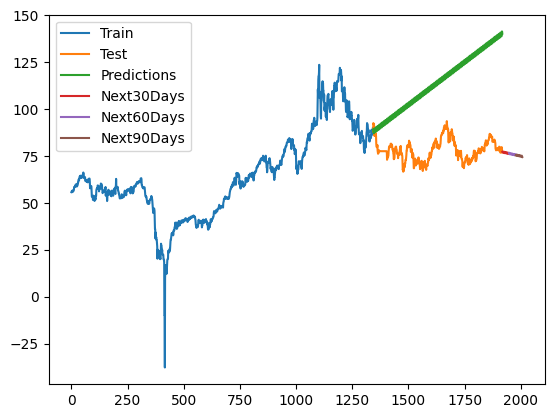

In [62]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, predictions_test_actual[0])
plt.plot(last_data_30, y_pred_future_30)
plt.plot(last_data_60, y_pred_future_60)
plt.plot(last_data_90, y_pred_future_90)
plt.legend(['Train', 'Test', 'Predictions','Next30Days','Next60Days','Next90Days'])
plt.savefig('crude.png')
plt.show()

### Gasoline RBOB

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt


# Đọc dữ liệu
df = pd.read_csv('../dataset/Gasoline RBOB.csv').dropna()

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]


In [64]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)


In [65]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,1.5356
1,1.5443
2,1.5443
3,1.553
4,1.5601
...,...
1914,2.514
1915,2.509
1916,2.4644
1917,2.4046


In [66]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [67]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

In [68]:
# Khởi tạo một mô hình DLM
myDLM = dlm(train_data.Price)

# Thêm trend
myDLM = myDLM + trend(degree=1, discount=0.9, name='linear_trend')

# Thêm seasonality
myDLM = myDLM + seasonality(period=7, discount=0.9, name='weekly_seasonality')

# Huấn luyện mô hình
myDLM.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [69]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = myDLM.predictN(N=len(y_test))

# Extract the last observation for initializing the forecast
last_observation = test_data.iloc[-1]['Price']

# Predict values for the test set based on actual data
predictions_test_actual = myDLM.predictN(N=len(test_data))

In [70]:
# Lấy 100 giá trị gần nhất từ tập dữ liệu kiểm tra
recent_test_data = test_data.tail(100)

# Thêm các giá trị này vào mô hình DLM
for i in range(len(recent_test_data)):
    myDLM.append([recent_test_data.iloc[i]['Price']])
    myDLM.fit()


Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [71]:
# Dự đoán 30 ngày
future_predictions_30 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  
    future_predictions_30.append(future_prediction)
    myDLM.append([future_prediction])  
    myDLM.fit()  

# Dự đoán 60 ngày
future_predictions_60 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0] 
    future_predictions_60.append(future_prediction)
    myDLM.append([future_prediction]) 
    myDLM.fit()  

# Dự đoán 90 ngày
future_predictions_90 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  
    future_predictions_90.append(future_prediction)
    myDLM.append([future_prediction])  
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [72]:
# Chuyển đổi dự đoán thành mảng numpy
y_pred_future_30 = np.array(future_predictions_30)
y_pred_future_60 = np.array(future_predictions_60)
y_pred_future_90 = np.array(future_predictions_90)

In [73]:
# Display results
print("Test Set Predictions Based on Actual Data:\n", predictions_test_actual[0])

print("Dự đoán 30 ngày tiếp theo:\n", y_pred_future_30)
print("Dự đoán 60 ngày tiếp theo:\n", y_pred_future_60)
print("Dự đoán 90 ngày tiếp theo:\n", y_pred_future_90)

Test Set Predictions Based on Actual Data:
 [2.528844114184715, 2.496509507119092, 2.4876187273850903, 2.4874575834462056, 2.4791474712094543, 2.521574786588876, 2.5805706759999314, 2.563151271503923, 2.5308166644383, 2.5219258847042982, 2.5217647407654136, 2.5134546285286623, 2.555881943908084, 2.6148778333191394, 2.597458428823131, 2.565123821757508, 2.556233042023506, 2.5560718980846215, 2.5477617858478703, 2.590189101227292, 2.6491849906383473, 2.631765586142339, 2.599430979076716, 2.590540199342714, 2.5903790554038295, 2.5820689431670782, 2.6244962585465, 2.6834921479575553, 2.6660727434615468, 2.633738136395924, 2.624847356661922, 2.6246862127230375, 2.616376100486286, 2.658803415865708, 2.7177993052767633, 2.7003799007807547, 2.668045293715132, 2.65915451398113, 2.6589933700422455, 2.650683257805494, 2.693110573184916, 2.7521064625959712, 2.7346870580999627, 2.70235245103434, 2.693461671300338, 2.6933005273614534, 2.684990415124702, 2.727417730504124, 2.786413619915179, 2.768994

In [74]:
eval(y_test,predictions_test_actual[0])

** Testing **
MAE:  1.4293264772900314
MAPE:  59.13865998876135
RMSE:  1.6628882886499494


In [75]:
last_index =  df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

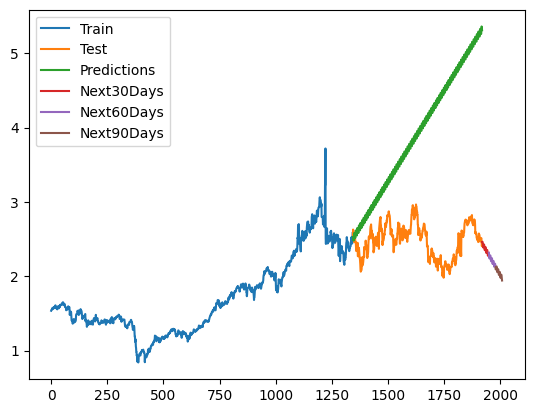

In [76]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, predictions_test_actual[0])
plt.plot(last_data_30, y_pred_future_30)
plt.plot(last_data_60, y_pred_future_60)
plt.plot(last_data_90, y_pred_future_90)
plt.legend(['Train', 'Test', 'Predictions','Next30Days','Next60Days','Next90Days'])
plt.savefig('gasoline.png')
plt.show()

### Heating Oil

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt


# Đọc dữ liệu
df = pd.read_csv('../dataset/Heating Oil.csv').dropna()

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]


In [78]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)


In [79]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.001
1,2.00765
2,2.00765
3,2.0143
4,2.0164
...,...
1914,2.4393
1915,2.465
1916,2.437
1917,2.3694


In [80]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [81]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

In [82]:
# Khởi tạo một mô hình DLM
myDLM = dlm(train_data.Price)

# Thêm trend
myDLM = myDLM + trend(degree=1, discount=0.9, name='linear_trend')

# Thêm seasonality
myDLM = myDLM + seasonality(period=7, discount=0.9, name='weekly_seasonality')

# Huấn luyện mô hình
myDLM.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [83]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = myDLM.predictN(N=len(y_test))

# Extract the last observation for initializing the forecast
last_observation = test_data.iloc[-1]['Price']

# Predict values for the test set based on actual data
predictions_test_actual = myDLM.predictN(N=len(test_data))

In [84]:
# Append test data to the DLM to incorporate its information
for i in range(len(test_data)):
    myDLM.append([test_data.iloc[i]['Price']])
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [85]:
# Dự đoán 30 ngày
future_predictions_30 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  
    future_predictions_30.append(future_prediction)
    myDLM.append([future_prediction])  
    myDLM.fit()  

# Dự đoán 60 ngày
future_predictions_60 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0] 
    future_predictions_60.append(future_prediction)
    myDLM.append([future_prediction]) 
    myDLM.fit()  

# Dự đoán 90 ngày
future_predictions_90 = []
for _ in range(30):
    future_prediction = myDLM.predictN(date=myDLM.n - 1, N=1)[0][0]  
    future_predictions_90.append(future_prediction)
    myDLM.append([future_prediction])  
    myDLM.fit()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fi

In [86]:
# Chuyển đổi dự đoán thành mảng numpy
y_pred_future_30 = np.array(future_predictions_30)
y_pred_future_60 = np.array(future_predictions_60)
y_pred_future_90 = np.array(future_predictions_90)

In [87]:
# Display results
print("Test Set Predictions Based on Actual Data:\n", predictions_test_actual[0])

print("Dự đoán 30 ngày tiếp theo:\n", y_pred_future_30)
print("Dự đoán 60 ngày tiếp theo:\n", y_pred_future_60)
print("Dự đoán 90 ngày tiếp theo:\n", y_pred_future_90)


Test Set Predictions Based on Actual Data:
 [4.267939201303177, 4.34997269101084, 4.260780168481516, 4.258966596079981, 4.164716309789052, 3.8668050927237956, 4.027969652027648, 4.397364603484738, 4.479398093192401, 4.390205570663078, 4.388391998261542, 4.294141711970613, 3.996230494905357, 4.157395054209209, 4.5267900056662995, 4.608823495373962, 4.519630972844639, 4.5178174004431035, 4.423567114152174, 4.125655897086919, 4.28682045639077, 4.656215407847861, 4.738248897555524, 4.6490563750262, 4.647242802624665, 4.5529925163337355, 4.255081299268479, 4.416245858572331, 4.785640810029422, 4.867674299737085, 4.7784817772077615, 4.776668204806226, 4.682417918515297, 4.384506701450041, 4.545671260753893, 4.915066212210983, 4.997099701918646, 4.907907179389323, 4.906093606987787, 4.811843320696858, 4.513932103631602, 4.675096662935454, 5.044491614392545, 5.126525104100208, 5.037332581570884, 5.035519009169349, 4.941268722878419, 4.643357505813164, 4.804522065117015, 5.173917016574106, 5.25

In [88]:
eval(y_test,predictions_test_actual[0])

** Testing **
MAE:  6.61689614357795
MAPE:  244.04655567151175
RMSE:  7.361731211910029


In [89]:
last_index =  df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

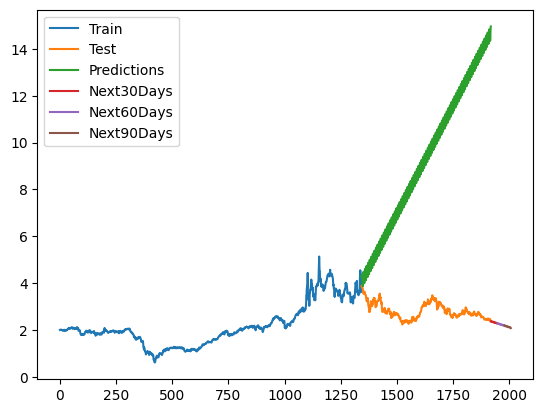

In [90]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, predictions_test_actual[0])
plt.plot(last_data_30, y_pred_future_30)
plt.plot(last_data_60, y_pred_future_60)
plt.plot(last_data_90, y_pred_future_90)
plt.legend(['Train', 'Test', 'Predictions','Next30Days','Next60Days','Next90Days'])
plt.savefig('heating.png')
plt.show()